In [1]:
# Temporary hack
import sys
sys.path.append("../../..")
import aqua

In [2]:
# Use this diagnostic to test the new aqua.docker.rundiag() function
# Everything is defined in the diagnostic.yaml and machine.yaml files
# If no argument is provided then the first command defined in machine.yaml is run
#output = aqua.docker.rundiag(cmd="detect")
detect_out = aqua.docker.rundiag(cmd="detect")
stitch_out = aqua.docker.rundiag(cmd="stitch")

In [5]:
import numpy as np
import re

# from https://github.com/zarzycki/cymep

def getTrajectories(filename,nVars,headerDelimStr,isUnstruc):
  print("Getting trajectories from TempestExtremes file...")
  print("Running getTrajectories on '%s' with unstruc set to '%s'" % (filename, isUnstruc))
  print("nVars set to %d and headerDelimStr set to '%s'" % (nVars, headerDelimStr))

  # Using the newer with construct to close the file automatically.
  with open(filename) as f:
      data = f.readlines()

  # Find total number of trajectories and maximum length of trajectories
  numtraj=0
  numPts=[]
  for line in data:
    if headerDelimStr in line:
      # if header line, store number of points in given traj in numPts
      headArr = line.split()
      numtraj += 1
      numPts.append(int(headArr[1]))
    else:
      # if not a header line, and nVars = -1, find number of columns in data point
      if nVars < 0:
        nVars=len(line.split())
  
  maxNumPts = max(numPts) # Maximum length of ANY trajectory

  print("Found %d columns" % nVars)
  print("Found %d trajectories" % numtraj)

  # Initialize storm and line counter
  stormID=-1
  lineOfTraj=-1

  # Create array for data
  if isUnstruc:
    prodata = np.empty((nVars+1,numtraj,maxNumPts))
  else:
    prodata = np.empty((nVars,numtraj,maxNumPts))

  prodata[:] = np.NAN

  for i, line in enumerate(data):
    if headerDelimStr in line:  # check if header string is satisfied
      stormID += 1      # increment storm
      lineOfTraj = 0    # reset trajectory line to zero
    else:
      ptArr = line.split()
      for jj in range(nVars):
        if isUnstruc:
          prodata[jj+1,stormID,lineOfTraj]=ptArr[jj]
        else:
          prodata[jj,stormID,lineOfTraj]=ptArr[jj]
      lineOfTraj += 1   # increment line

  print("... done reading data")
  return numtraj, maxNumPts, prodata




def getNodes(filename,nVars,isUnstruc):
  print("Getting nodes from TempestExtremes file...")

  # Using the newer with construct to close the file automatically.
  with open(filename) as f:
      data = f.readlines()

  # Find total number of trajectories and maximum length of trajectories
  numnodetimes=0
  numPts=[]
  for line in data:
    if re.match(r'\w', line):
      # if header line, store number of points in given traj in numPts
      headArr = line.split()
      numnodetimes += 1
      numPts.append(int(headArr[3]))
    else:
      # if not a header line, and nVars = -1, find number of columns in data point
      if nVars < 0:
        nVars=len(line.split())
  
  maxNumPts = max(numPts) # Maximum length of ANY trajectory

  print("Found %d columns" % nVars)
  print("Found %d trajectories" % numnodetimes)
  print("Found %d maxNumPts" % maxNumPts)

  # Initialize storm and line counter
  stormID=-1
  lineOfTraj=-1

  # Create array for data
  if isUnstruc:
    prodata = np.empty((nVars+5,numnodetimes,maxNumPts))
  else:
    prodata = np.empty((nVars+4,numnodetimes,maxNumPts))

  prodata[:] = np.NAN

  nextHeadLine=0
  for i, line in enumerate(data):
    if re.match(r'\w', line):  # check if header string is satisfied
      stormID += 1      # increment storm
      lineOfTraj = 0    # reset trajectory line to zero
      headArr = line.split()
      YYYY = int(headArr[0])
      MM = int(headArr[1])
      DD = int(headArr[2])
      HH = int(headArr[4])
    else:
      ptArr = line.split()
      for jj in range(nVars-1):
        if isUnstruc:
          prodata[jj+1,stormID,lineOfTraj]=ptArr[jj]
        else:
          prodata[jj,stormID,lineOfTraj]=ptArr[jj]
      if isUnstruc:
        prodata[nVars+1,stormID,lineOfTraj]=YYYY
        prodata[nVars+2,stormID,lineOfTraj]=MM
        prodata[nVars+3,stormID,lineOfTraj]=DD
        prodata[nVars+4,stormID,lineOfTraj]=HH
      else:
        prodata[nVars  ,stormID,lineOfTraj]=YYYY
        prodata[nVars+1,stormID,lineOfTraj]=MM
        prodata[nVars+2,stormID,lineOfTraj]=DD
        prodata[nVars+3,stormID,lineOfTraj]=HH
      lineOfTraj += 1   # increment line

  print("... done reading data")
  return numnodetimes, maxNumPts, prodata

In [6]:
import os
os.chdir("/work/users/jost/docker/tempest")

Getting trajectories from TempestExtremes file...
Running getTrajectories on '/work/users/jost/docker/tempest/ERA5_TC_tracks.txt' with unstruc set to '0'
nVars set to -1 and headerDelimStr set to 'start'
Found 11 columns
Found 60 trajectories
... done reading data


/home/jost/miniconda3/envs/cats/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/jost/miniconda3/envs/cats/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/home/jost/miniconda3/envs/cats/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


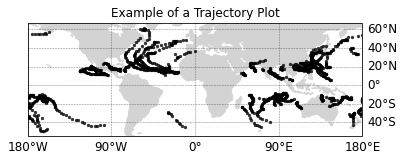

In [17]:
import datetime as dt
from netCDF4 import Dataset, date2num
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import netCDF4 as nc

from cartopy import config
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

#import tempest_lib as tmp

data_path = "/work/users/jost/docker/tempest/"
trajfile = data_path + "ERA5_TC_tracks.txt"
plotdir = "/work/users/jost/docker/tempest/"

nVars=-1
headerStr='start'
isUnstruc = 0

# Extract trajectories from tempest file and assign to arrays
# USER_MODIFY
nstorms, ntimes, traj_data = getTrajectories(trajfile,nVars,headerStr,isUnstruc)
xlon   = traj_data[2,:,:]
xlat   = traj_data[3,:,:]
xpres  = traj_data[4,:,:]/100.
xwind  = traj_data[5,:,:]
xyear  = traj_data[7,:,:]
xmonth = traj_data[8,:,:]

# Initialize axes
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-180, 180, -75, 75], crs=None)

# Set title and subtitle
plt.title('Example of a Trajectory Plot')


# Set land feature and change color to 'lightgrey'
# See link for extensive list of colors:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
ax.add_feature(cfeature.LAND, color='lightgrey')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
#gl.xlines = False
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 12, 'color': 'black'}
gl.xlabel_style = {'size': 12, 'color': 'black'}



# Plot each trajectory
for i in range(nstorms):

        # doesn't work with cartopy!
        #plt.plot(xlon[i], xlat[i], linewidth=0.4)



    plt.scatter(x=xlon[i], y=xlat[i],
                                                color="black",
                                                s=30,
                                                linewidths=0.5,
                                                marker=".",
                                                alpha=0.8,
                                                transform=ccrs.PlateCarree()) ## Important


plt.savefig(plotdir + "prova_TC_2010.png", bbox_inches='tight', dpi=350)